## 1. Draw a Bayesnet

In [33]:
import probml_utils.pgmpy_utils as pgm
from causalgraphicalmodels import CausalGraphicalModel
# Note: If you are using python 3.3 or greater, you will need to update collections to collections.abc
import pgmpy
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, PC, TreeSearch, BicScore
df = pd.read_csv('data_processed-v3.csv')

In [34]:
df.head(2)

,gender,age_group,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,glucose_level_group,bmi_group
0,Male,Old,hypertension_No,heart_disease_Yes,Yes,Work,Urban,formerly smoked,stroke_Yes,High,Obese
1,Male,Old,hypertension_No,heart_disease_Yes,Yes,Work,Rural,never smoked,stroke_Yes,Low,Obese


In [5]:
target = 'stroke'
var1 = 'heart_disease'
var2 = 'Residence_type'
# Define the model structure
model = BayesianNetwork([(var1, target),(var2, target)])


state_names = {
    "heart_disease": sorted(df[var1].unique().tolist()),               # ['high', 'low', 'medium']
    "Residence_type": sorted(df[var2].unique().tolist()),     # ['no', 'yes']
    "stroke": sorted(df[target].unique().tolist())      # ['no', 'yes']
}

model.fit(df, estimator=MaximumLikelihoodEstimator, state_names=state_names)

In [6]:
for cpd in model.get_cpds():
    print(cpd)
model.check_model()

+----------------------------------+----------+
| heart_disease(heart_disease_No)  | 0.939854 |
+----------------------------------+----------+
| heart_disease(heart_disease_Yes) | 0.060146 |
+----------------------------------+----------+
+--------------------+-----+----------------------------------+
| Residence_type     | ... | Residence_type(Urban)            |
+--------------------+-----+----------------------------------+
| heart_disease      | ... | heart_disease(heart_disease_Yes) |
+--------------------+-----+----------------------------------+
| stroke(stroke_No)  | ... | 0.8256880733944955               |
+--------------------+-----+----------------------------------+
| stroke(stroke_Yes) | ... | 0.1743119266055046               |
+--------------------+-----+----------------------------------+
+-----------------------+----------+
| Residence_type(Rural) | 0.490511 |
+-----------------------+----------+
| Residence_type(Urban) | 0.509489 |
+-----------------------+----------+

True

In [7]:
from sklearn.model_selection import train_test_split
data = df.copy()

In [25]:
random_state = 3003
train_data, test_data = train_test_split(data, test_size =0.3, random_state = random_state)


  0%|          | 0/5 [00:00<?, ?it/s]

[('ever_married', 'bmi_group'), ('ever_married', 'age_group'), ('hypertension', 'age_group'), ('stroke', 'age_group'), ('heart_disease', 'age_group'), ('work_type', 'bmi_group'), ('work_type', 'ever_married'), ('glucose_level_group', 'hypertension')]
+-------------------+-------------------------+---------------------+
| work_type         | work_type(Never_worked) | work_type(Work)     |
+-------------------+-------------------------+---------------------+
| ever_married(No)  | 1.0                     | 0.21638924455825864 |
+-------------------+-------------------------+---------------------+
| ever_married(Yes) | 0.0                     | 0.7836107554417413  |
+-------------------+-------------------------+---------------------+
+------------------------+-----+----------------------+
| ever_married           | ... | ever_married(Yes)    |
+------------------------+-----+----------------------+
| work_type              | ... | work_type(Work)      |
+------------------------+-----+---

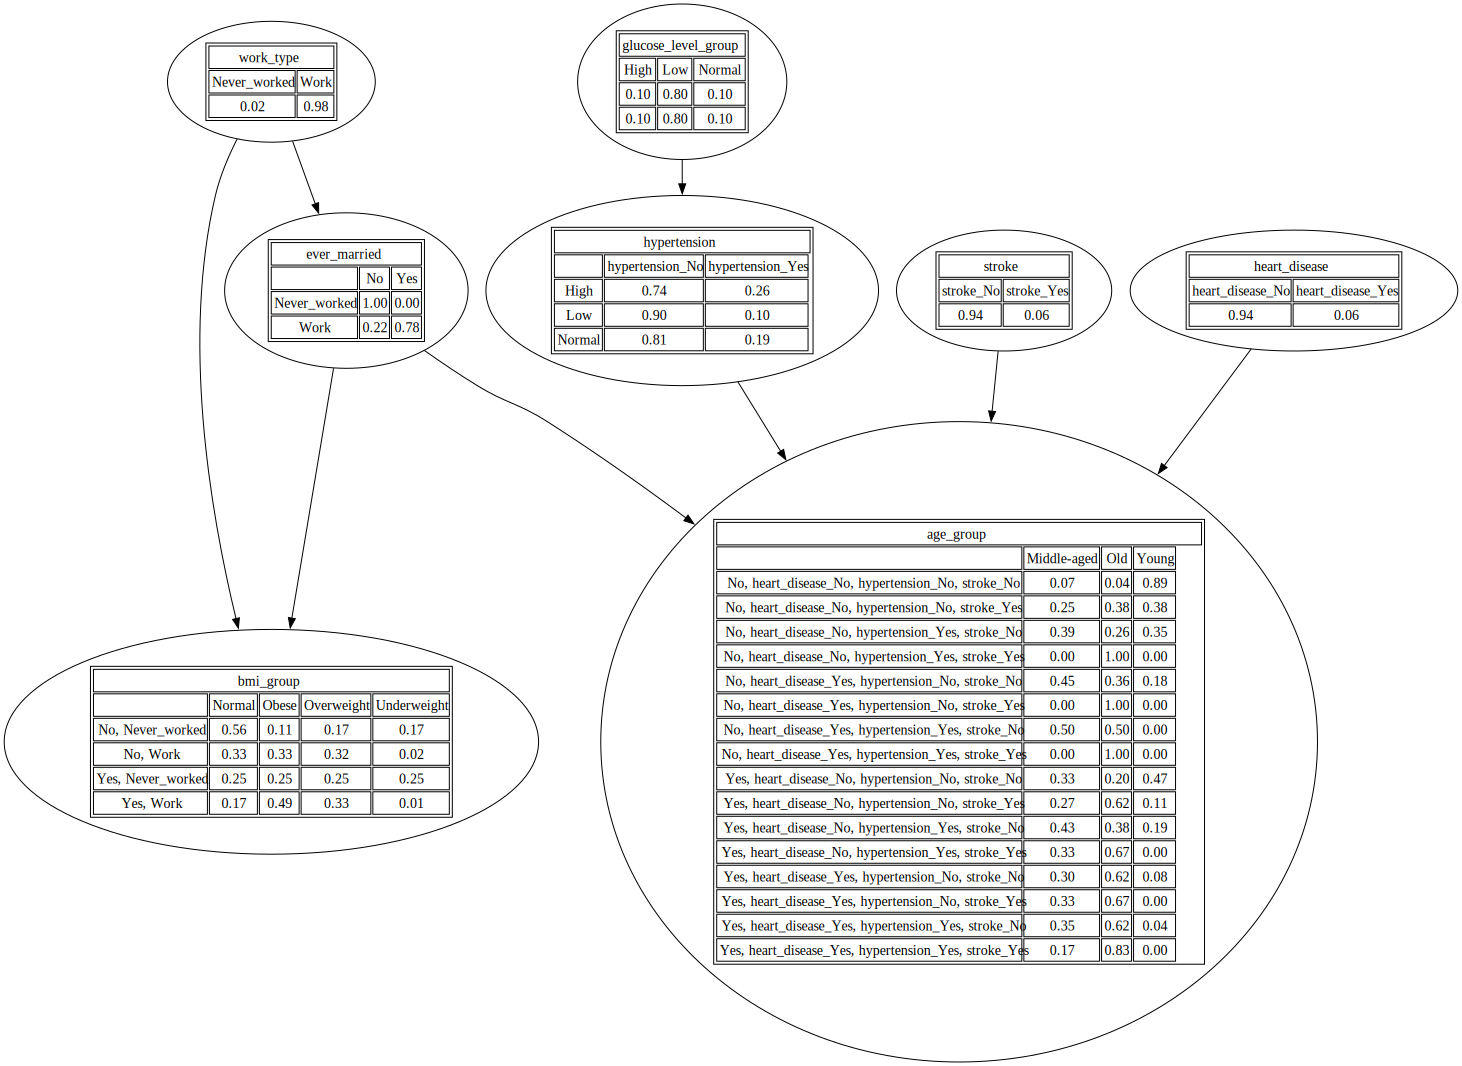

In [26]:
# 1) pc
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
pc_est = PC(data=train_data)
pc_model = pc_est.estimate()

pc_bn = BayesianNetwork(pc_model.edges())
pc_bn.fit(train_data)

# structure
print(pc_bn.edges())
# CPT
for cpd in pc_bn.get_cpds():
    print(cpd)

dot = pgm.visualize_model(pc_bn)
display(dot)

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('age_group', 'ever_married'), ('age_group', 'hypertension'), ('age_group', 'stroke'), ('age_group', 'glucose_level_group'), ('age_group', 'smoking_status'), ('ever_married', 'work_type'), ('ever_married', 'bmi_group'), ('heart_disease', 'age_group'), ('bmi_group', 'gender')]
+------------------------+-----+----------------------------------+
| heart_disease          | ... | heart_disease(heart_disease_Yes) |
+------------------------+-----+----------------------------------+
| age_group(Middle-aged) | ... | 0.31724137931034485              |
+------------------------+-----+----------------------------------+
| age_group(Old)         | ... | 0.6206896551724138               |
+------------------------+-----+----------------------------------+
| age_group(Young)       | ... | 0.06206896551724138              |
+------------------------+-----+----------------------------------+
+-------------------+-----+--------------------+
| age_group         | ... | age_group(Young)   |
+-----------

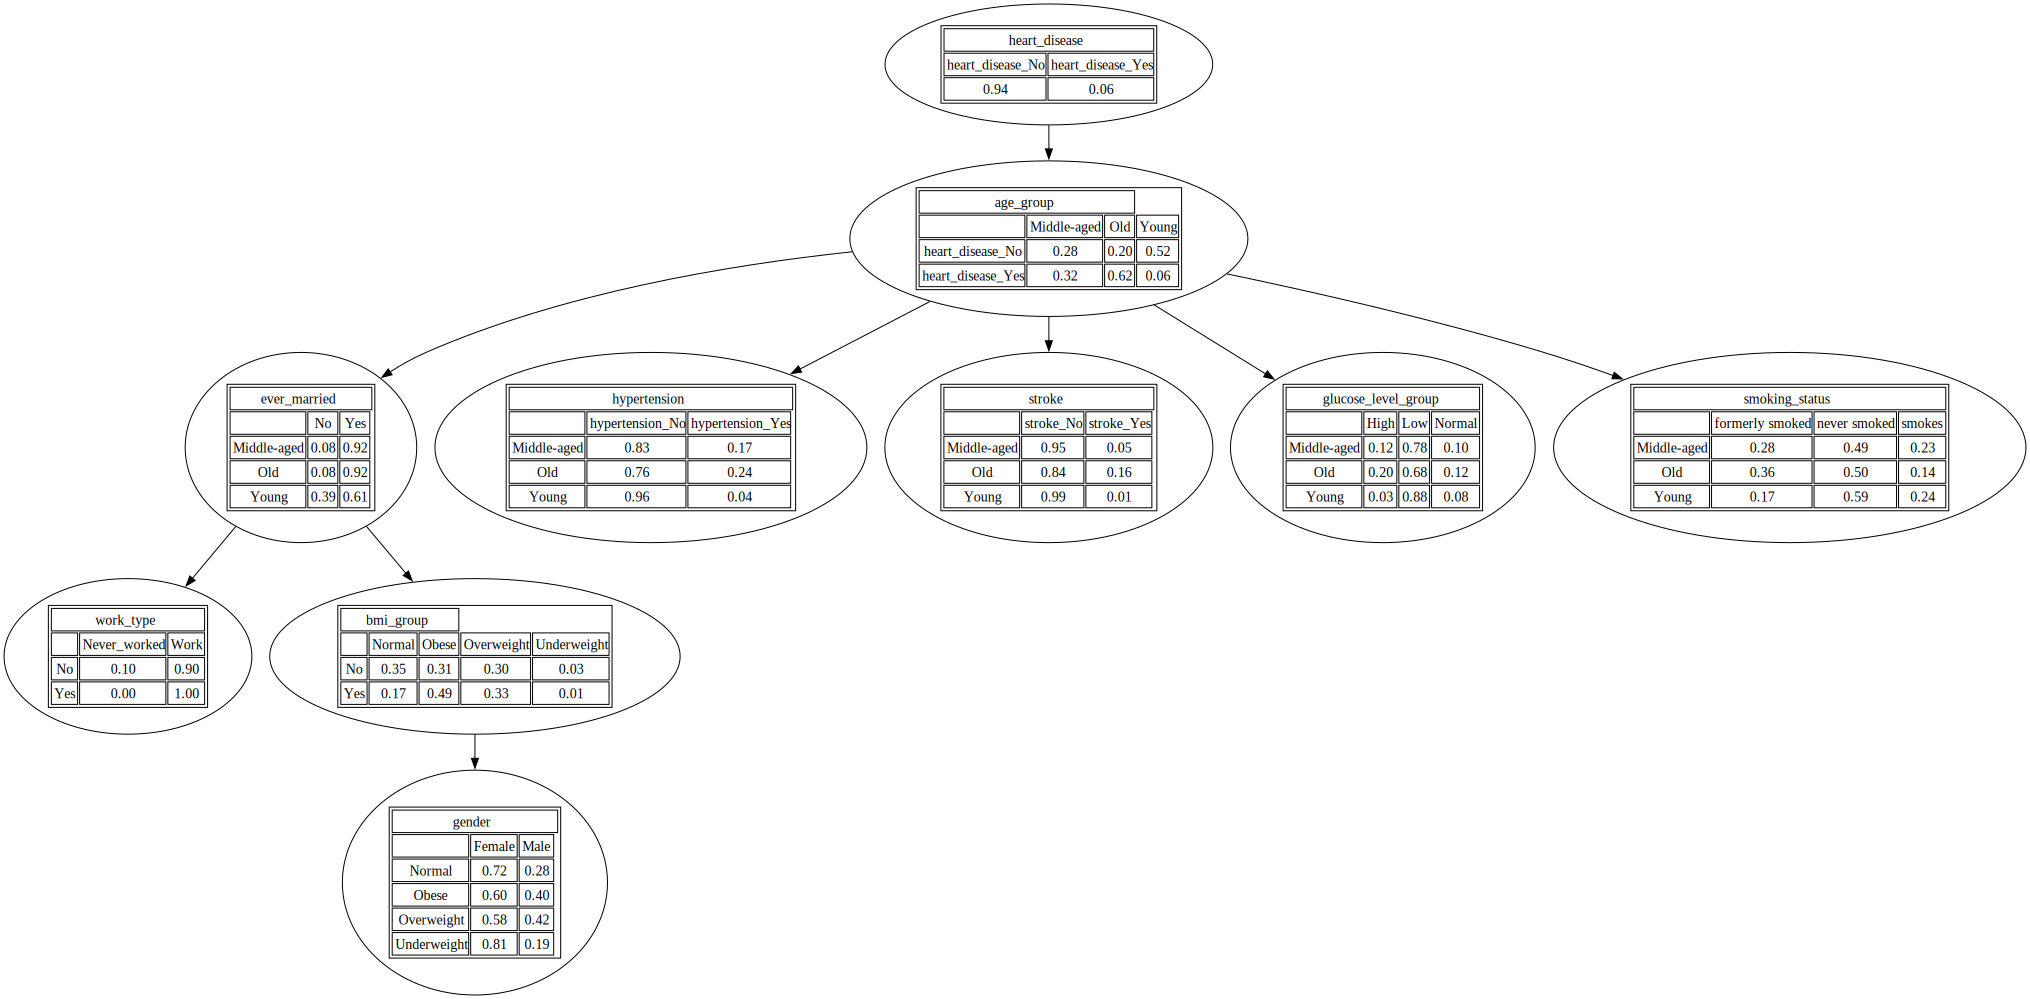

In [27]:
# 2) hill climb
# 3000, 3006, 2025
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

train_data, test_data = train_test_split(data, test_size =0.3, random_state = random_state)
hc_est = HillClimbSearch(train_data)
hc_model = hc_est.estimate(scoring_method=BicScore(train_data))

hc_bn = BayesianNetwork(hc_model.edges())
hc_bn.fit(train_data)

# 구조 + CPT
print(hc_bn.edges())
for cpd in hc_bn.get_cpds():
    print(cpd)

dot = pgm.visualize_model(hc_bn)
display(dot)

Building tree:   0%|          | 0/55.0 [00:00<?, ?it/s]

[('age_group', 'ever_married'), ('age_group', 'hypertension'), ('age_group', 'heart_disease'), ('age_group', 'stroke'), ('age_group', 'glucose_level_group'), ('age_group', 'smoking_status'), ('age_group', 'Residence_type'), ('ever_married', 'work_type'), ('ever_married', 'bmi_group'), ('bmi_group', 'gender')]
+------------------------+----------+
| age_group(Middle-aged) | 0.279099 |
+------------------------+----------+
| age_group(Old)         | 0.229871 |
+------------------------+----------+
| age_group(Young)       | 0.49103  |
+------------------------+----------+
+-------------------+-----+--------------------+
| age_group         | ... | age_group(Young)   |
+-------------------+-----+--------------------+
| ever_married(No)  | ... | 0.3925233644859813 |
+-------------------+-----+--------------------+
| ever_married(Yes) | ... | 0.6074766355140186 |
+-------------------+-----+--------------------+
+--------------------------------+-----+---------------------+
| age_group      

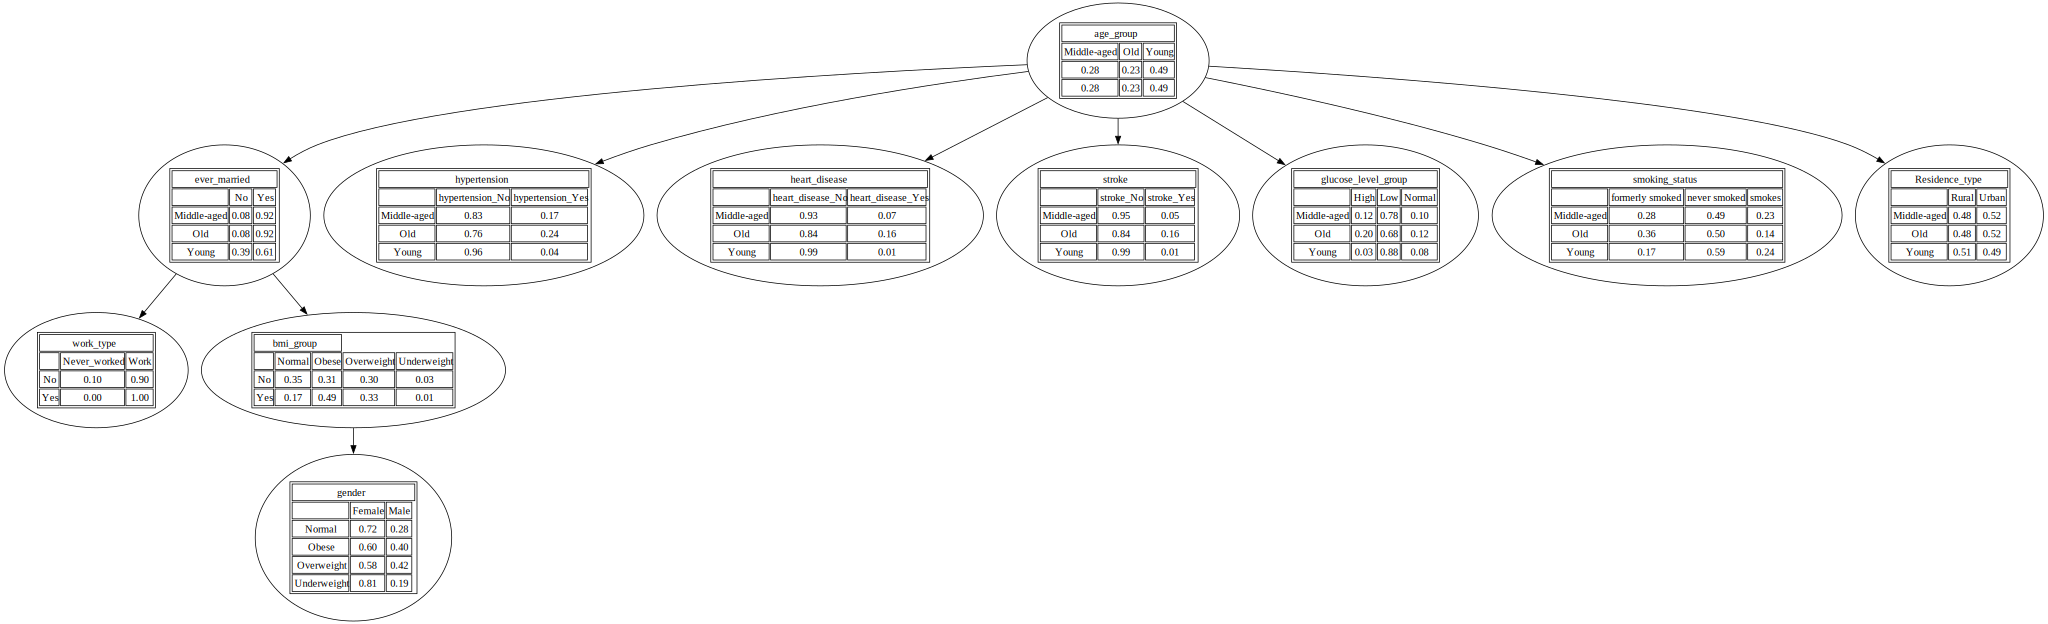

In [28]:
# 3) Tree search
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from pgmpy.estimators import TreeSearch

ts_est = TreeSearch(train_data)
ts_model = ts_est.estimate()

ts_bn = BayesianNetwork(ts_model.edges())
ts_bn.fit(train_data)

# 구조 + CPT
print(ts_bn.edges())
for cpd in ts_bn.get_cpds():
    print(cpd)


dot = pgm.visualize_model(ts_bn)
display(dot)

In [29]:
# the lower the better
from pgmpy.metrics import structure_score

# HC subset
hc_nodes = [n for n in hc_bn.nodes() if n in test_data.columns]
test_data_hc = test_data[hc_nodes]

# TS subset
ts_nodes = [n for n in ts_bn.nodes() if n in test_data.columns]
test_data_ts = test_data[ts_nodes]

# compare score
score_hc = structure_score(hc_bn, test_data_hc, scoring_method="bic")
score_ts = structure_score(ts_bn, test_data_ts, scoring_method="bic")

print(f"Hill Climb BIC: {score_hc:.2f}")
print(f"Tree Search BIC: {score_ts:.2f}")


Hill Climb BIC: -5894.48
Tree Search BIC: -6615.68


In [35]:
df

,gender,age_group,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,glucose_level_group,bmi_group
0,Male,Old,hypertension_No,heart_disease_Yes,Yes,Work,Urban,formerly smoked,stroke_Yes,High,Obese
1,Male,Old,hypertension_No,heart_disease_Yes,Yes,Work,Rural,never smoked,stroke_Yes,Low,Obese
2,Female,Young,hypertension_No,heart_disease_No,Yes,Work,Urban,smokes,stroke_Yes,Normal,Obese
3,Female,Old,hypertension_Yes,heart_disease_No,Yes,Work,Rural,never smoked,stroke_Yes,Normal,Normal
4,Male,Old,hypertension_No,heart_disease_No,Yes,Work,Urban,formerly smoked,stroke_Yes,Normal,Overweight
...,...,...,...,...,...,...,...,...,...,...,...
3420,Male,Old,hypertension_Yes,heart_disease_No,Yes,Work,Rural,never smoked,stroke_No,Low,Overweight
3421,Female,Middle-aged,hypertension_No,heart_disease_No,Yes,Work,Rural,never smoked,stroke_No,Low,Normal
3422,Female,Old,hypertension_No,heart_disease_No,Yes,Work,Urban,never smoked,stroke_No,Low,Obese
3423,Female,Young,hypertension_No,heart_disease_No,Yes,Work,Rural,never smoked,stroke_No,Low,Obese


In [41]:
df.head(1)

,gender,age_group,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,glucose_level_group,bmi_group
0,Male,Old,hypertension_No,heart_disease_Yes,Yes,Work,Urban,formerly smoked,stroke_Yes,High,Obese


In [46]:
### age
# Doing exact inference using Variable Elimination
infer = VariableElimination(ts_bn)

evidence = {'age_group': 'Young'}
postD_exercise_low = infer.query(["stroke"], evidence=evidence)
print(postD_exercise_low)

evidence = {'age_group': 'Old'}
postD_exercise_high = infer.query(["stroke"], evidence=evidence)
print(postD_exercise_high)



0it [00:00, ?it/s]

0it [00:00, ?it/s]

+--------------------+---------------+
| stroke             |   phi(stroke) |
+====================+===============+
| stroke(stroke_No)  |        0.9915 |
+--------------------+---------------+
| stroke(stroke_Yes) |        0.0085 |
+--------------------+---------------+


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+--------------------+---------------+
| stroke             |   phi(stroke) |
+====================+===============+
| stroke(stroke_No)  |        0.8403 |
+--------------------+---------------+
| stroke(stroke_Yes) |        0.1597 |
+--------------------+---------------+
